In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip 'drive/MyDrive/fruit.zip' -d 'drive/MyDrive/'

Streaming output truncated to the last 5000 lines.
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_290_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_291_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_292_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_293_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_294_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_295_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_296_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_297_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_298_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_299_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_2_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_300_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_301_100.jpg  
  inflating: drive/MyDrive/fruit/Training/Tomato 2/r_302_100.jpg  
  inflating: 

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential,Model
import tensorflow as tf
import tensorflow_hub as hub 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install split-folders

In [3]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# Check for TPU
print("GPU", "available (YESS!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF version: 2.4.1
Hub version: 0.12.0
GPU available (YESS!!!!)


In [4]:
import splitfolders

In [5]:
input = 'drive/MyDrive/fruit/Training'
output = 'drive/MyDrive/fruit_datasets'
splitfolders.ratio(input,output,seed = 224, ratio = (0.6,0.2,0.2))

Copying files: 297 files [00:50,  1.63 files/s]

KeyboardInterrupt: ignored

In [ ]:
img_width, img_height = (224,224)
batch_size = 32
train_data_directory = "drive/MyDrive/fruit_dataset/train"
val_data_directory = "drive/MyDrive/fruit_dataset/val"
test_data_directory = "drive/MyDrive/fruit/Test"

In [ ]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rescale=1./255,shear_range=0.1,zoom_range=0.1,horizontal_flip=True)
train_generator = datagen.flow_from_directory(train_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size)
val_generator = datagen.flow_from_directory(val_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=batch_size)

FileNotFoundError: ignored

In [ ]:
test_generator = datagen.flow_from_directory(test_data_directory, 
                                                    target_size=(img_width, img_height), 
                                                    class_mode='categorical', 
                                                    batch_size=1)

Found 22688 images belonging to 131 classes.


In [ ]:
x,y = test_generator.next()
x.shape

(1, 224, 224, 3)

In [ ]:
INPUT_SHAPE = [None, img_height, img_width, 3] # batch, height, width, colour channels

# Setup output shape of our model
OUTPUT_SHAPE = train_generator.num_classes

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4"

In [ ]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Layer 1 (input layer)
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax") # Layer 2 (output layer)
  ])

  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [ ]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/4
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 1001)              4254889   
_________________________________________________________________
dense_2 (Dense)              (None, 131)               131262    
Total params: 4,386,151
Trainable params: 131,262
Non-trainable params: 4,254,889
_________________________________________________________________


In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import datetime
import os
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/MyDrive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=2)

In [ ]:
NUM_EPOCHS = 5 #@param {type:"slider", min:5, max:100, step:5}

In [ ]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_generator,
            epochs=NUM_EPOCHS,
            validation_data=val_generator,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [ ]:
#Fit the model to the data
model = train_model()

NameError: ignored

In [ ]:
# Create a function to save a model
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (string).
  """
  # Create a model directory pathname with current time
  modeldir = os.path.join("drive/MyDrive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
# Save our model trained on whole images
save_model(model, suffix="images-efficientnet/b0")

Saving model to: drive/MyDrive/Data/models/20210420-05471618897652-images-mobilenetv1-Adam.h5...


'drive/MyDrive/Data/models/20210420-05471618897652-images-mobilenetv1-Adam.h5'

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path, 
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
model = load_model('drive/MyDrive/Data/models/20210420-05471618897652-images-mobilenetv1-Adam.h5')

Loading saved model from: drive/MyDrive/Data/models/20210420-05471618897652-images-mobilenetv1-Adam.h5


In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

10885/10885 [==============================] - 166s 15ms/step - loss: 0.2623 - accuracy: 0.9309


In [ ]:
predictions = model.predict(test_generator,verbose = 2)
predictions

10885/10885 - 138s


array([[5.63e-11, 3.40e-13, 1.26e-07, ..., 1.38e-06, 3.22e-17, 5.78e-17],
       [4.72e-11, 5.36e-11, 1.17e-05, ..., 3.00e-09, 1.87e-20, 1.84e-19],
       [1.07e-13, 5.13e-19, 6.83e-18, ..., 3.24e-12, 4.79e-22, 7.24e-16],
       ...,
       [2.61e-19, 3.60e-18, 4.18e-18, ..., 1.00e+00, 5.80e-09, 1.03e-13],
       [2.24e-10, 1.21e-11, 1.27e-10, ..., 3.27e-15, 4.65e-18, 6.19e-15],
       [2.82e-13, 1.18e-18, 5.32e-12, ..., 5.91e-12, 7.95e-22, 2.10e-14]],
      dtype=float32)

In [ ]:
import seaborn as sn
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob = []
y_act = []
for _ in range(nb_samples):
  X_test,Y_test = test_generator.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

In [ ]:
predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob ]
actual_class = [list(test_generator.class_indices.keys())[i.argmax()] for i in y_act ]

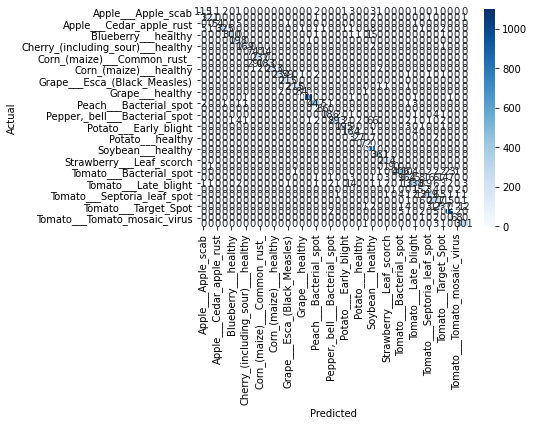

test_accuracy : 93.50482315112541


In [ ]:
out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T, columns = ['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['predicted_class'],out_df['actual_class'], rownames = ['Actual'], colnames = ['Predicted'])
sn.heatmap(confusion_matrix, cmap = 'Blues', annot = True, fmt = 'd')
plt.show()
print('test_accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  unique_breeds = [list(test_generator.class_indices.keys())[i.argmax()] for i in y_prob ]
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[30])
pred_label

'Squash___Powdery_mildew'

In [ ]:
filenames_n = ['drive/MyDrive/plants_disease_dataset/test/' + fname for fname in test_generator.filenames]

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  # Get the pred label
  
  pred_label = get_pred_label(pred_prob)
  # Plot image & remove ticks
  import matplotlib.image as mpimg
  plt.imshow(mpimg.imread(image))
  plt.xticks([])
  plt.yticks([])

  # Change the colour of the title depending on if the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"
  
  # Change plot title to be predicted, probability of prediction and truth label
  plt.title("{} {:2.0f}% {}".format(pred_label,
                                    np.max(pred_prob)*100,
                                    true_label),
                                    color=color)

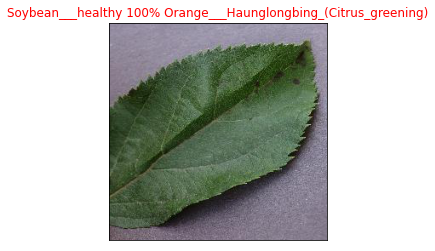

In [ ]:
plot_pred(prediction_probabilities=predictions,
          labels=actual_class,
          images=filenames_n,
          n=100)

Apple___Cedar_apple_rust


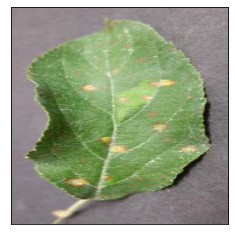

In [ ]:
import os
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # image path
    img_path = '/content/drive/MyDrive/plants_disease_dataset/test/Apple___Cedar_apple_rust/e733b839-3fac-4c4e-ac1c-38fa89c1e739___FREC_C.Rust 3546.JPG'
    #img_path = '/media/data/dogscats/test1/19.jpg'      # cat
    # load a single image
    new_image = load_image(img_path)
    import matplotlib.image as mpimg
    plt.imshow(mpimg.imread(img_path))
    plt.xticks([])
    plt.yticks([])
    # check prediction
    pred = model.predict(new_image)
    unique_class = test_generator.class_indices
    newlist = []
    for i in unique_class.keys():
      newlist.append(i)
    print(newlist[pred.argmax()])

In [ ]:
newlist

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Blueberry___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_